# Modelo de clasificación por tipo de espacio

### Importaciones

In [104]:
import numpy as np
import os
import PIL
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
from datetime import datetime
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

### Construcción de dataset

In [88]:
#Preprocesamiento de los datos
directory="E:/TesisMA/Datos/DataAmoblado/New_Model"
#directory1="E:/TesisMA/Datos/DataB"
img_height=256
img_width=256
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))


Found 5768 files belonging to 6 classes.
Using 4615 files for training.
Found 5768 files belonging to 6 classes.
Using 1153 files for validation.


### Analisis del dataset

In [89]:
class_names = train_ds.class_names
print(class_names)
num_classes = 6

['No_amoblado', 'bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room']


[531, 1215, 571, 502, 1198, 598]


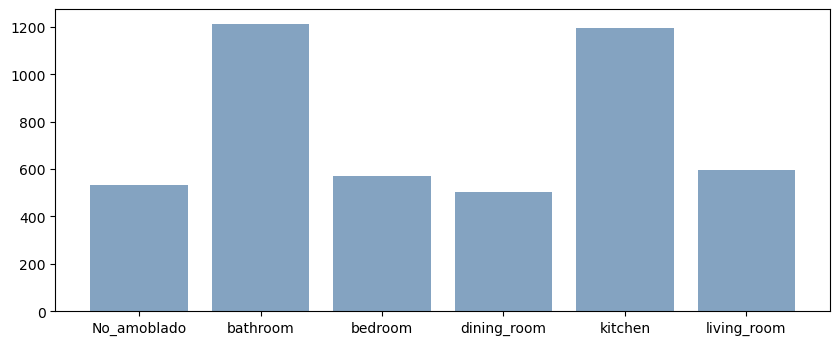

In [90]:
y = np.concatenate([y for x, y in train_ds], axis=0)
labels = list(y)
elements_per_class = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class.append(labels.count(i))
print(elements_per_class)
plt.bar(class_names,elements_per_class,color=(0.2, 0.4, 0.6, 0.6));

1153


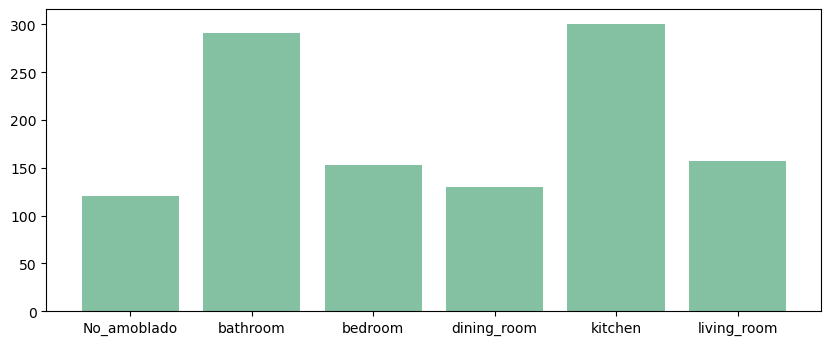

In [91]:
labels1 = np.concatenate([y for x, y in val_ds], axis=0)
labels1 = list(labels1)
elements_per_class1 = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class1.append(labels1.count(i))
print(sum(elements_per_class1))
plt.bar(class_names,elements_per_class1,color=(0.2, 0.6, 0.4, 0.6));

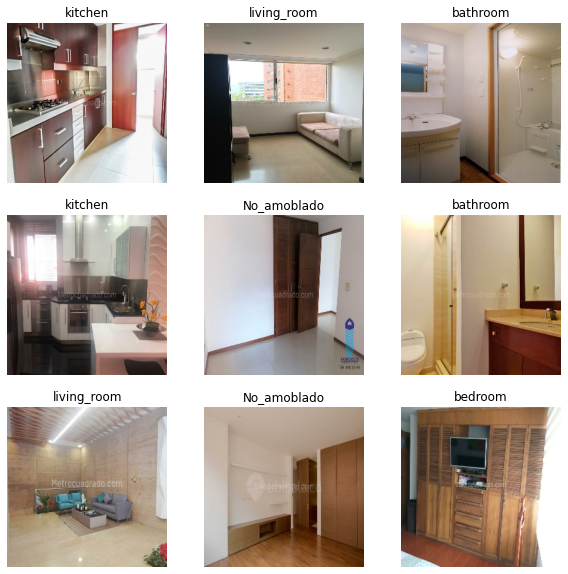

In [68]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [107]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [123]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

### CNN

In [129]:
model = Sequential([
  #Capa para realizar data augmantation
  data_augmentation,
  #Priemera capa entrada de 256x256 x3 canales de color
  layers.experimental.preprocessing.Rescaling(1/255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  #layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(512,activation="relu", kernel_initializer="he_normal"),
  #layers.BatchNormalization(),
  layers.Dense(256,activation="relu", kernel_initializer="he_normal"),
  #layers.BatchNormalization(),
  layers.Dense(6, activation='softmax')
])

### LRF Finder

In [130]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [131]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_13 (Rescaling)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 64, 64, 64)      

In [132]:
checkpoint_filepath="E:/TesisMA/Modelos/Amoblado/New_Moeld_6_Classes_3Convs_Droput05_lr_0001"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
epochs=120
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs,
callbacks=[model_checkpoint_callback]
)

Epoch 1/120
145/145 [==============================] - 200s 1s/step - loss: 1.6662 - accuracy: 0.3259 - val_loss: 1.7044 - val_accuracy: 0.3669
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos/Amoblado\New_Moeld_6_Classes_3Convs_Droput05_lr_0001\assets
Epoch 2/120
145/145 [==============================] - 228s 2s/step - loss: 1.5262 - accuracy: 0.3857 - val_loss: 1.5093 - val_accuracy: 0.3738
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos/Amoblado\New_Moeld_6_Classes_3Convs_Droput05_lr_0001\assets
Epoch 3/120
145/145 [==============================] - 211s 1s/step - loss: 1.4964 - accuracy: 0.3874 - val_loss: 1.4374 - val_accuracy: 0.4102
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos/Amoblado\New_Moeld_6_Classes_3Convs_Droput05_lr_0001\assets
Epoch 4/120
145/145 [==============================] - 224s 2s/step - loss: 1.4412 - accuracy: 0.4100 - val_loss: 1.5022 - val_accuracy: 0.3781
Epoch 5/120
145/145 [==============================] - 229s 2s/step - loss: 1.4037

Epoch 44/120
145/145 [==============================] - 210s 1s/step - loss: 0.6847 - accuracy: 0.7426 - val_loss: 0.9295 - val_accuracy: 0.6852
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos/Amoblado\New_Moeld_6_Classes_3Convs_Droput05_lr_0001\assets
Epoch 45/120
145/145 [==============================] - 212s 1s/step - loss: 0.6733 - accuracy: 0.7506 - val_loss: 0.9208 - val_accuracy: 0.6791
Epoch 46/120
145/145 [==============================] - 210s 1s/step - loss: 0.6760 - accuracy: 0.7447 - val_loss: 0.9377 - val_accuracy: 0.6696
Epoch 47/120
145/145 [==============================] - 213s 1s/step - loss: 0.6896 - accuracy: 0.7406 - val_loss: 0.9440 - val_accuracy: 0.6592
Epoch 48/120
145/145 [==============================] - 210s 1s/step - loss: 0.6812 - accuracy: 0.7445 - val_loss: 0.9664 - val_accuracy: 0.6661
Epoch 49/120
145/145 [==============================] - 211s 1s/step - loss: 0.6634 - accuracy: 0.7536 - val_loss: 0.9069 - val_accuracy: 0.6956
INFO:tensorflow:

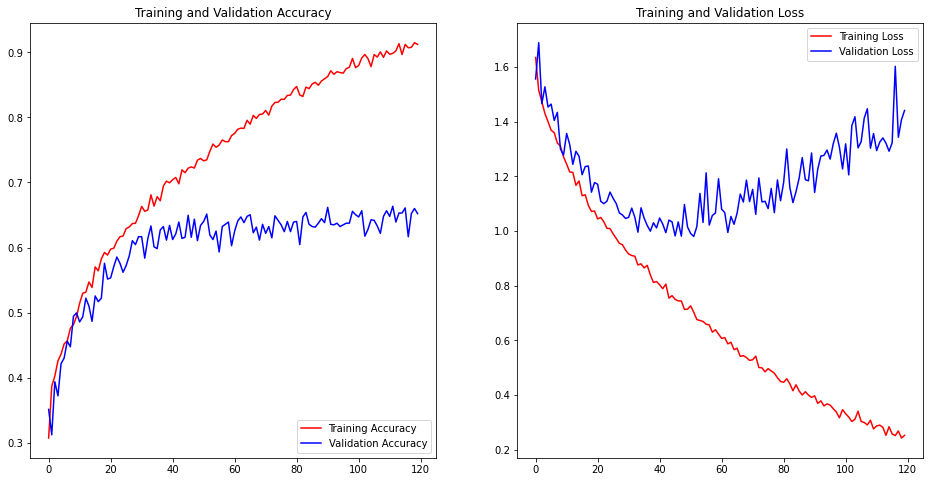

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

sn.set_palette(sn.color_palette("husl", 2))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss',color='blue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Confusion matrix

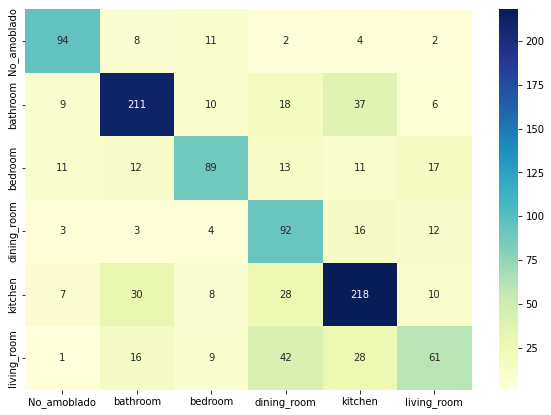

In [120]:
model = tf.keras.models.load_model(checkpoint_filepath)
labels= np.concatenate([y for x, y in val_ds], axis=0)
predictions = np.argmax(model.predict(val_ds),axis=-1)
matriz = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
df_cm = pd.DataFrame(matriz, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu",  fmt='g');

In [121]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       121
           1       0.75      0.73      0.74       291
           2       0.68      0.58      0.63       153
           3       0.47      0.71      0.57       130
           4       0.69      0.72      0.71       301
           5       0.56      0.39      0.46       157

    accuracy                           0.66      1153
   macro avg       0.65      0.65      0.64      1153
weighted avg       0.67      0.66      0.66      1153



In [37]:
metricasCM(matriz)

De todas las X clasificadas solo el %  fue correcto [0.89, 0.79]
De todas las que deberían ser clasificadas como X el % fue corrcto  [0.76, 0.39]


In [87]:
report = model.evaluate(val_ds,return_dict=True)
index=["Values"]
table=pd.DataFrame(report,index=index) 
table

37/37 [==============================] - 11s 282ms/step - loss: 1.0084 - accuracy: 0.6947


,loss,accuracy
Values,1.00835,0.694709


In [36]:
def metricasCM(matriz):
    # Bien clasificados sobre columna / De todas las X clasificadas solo el %  fue correcto
    metrica1= []
    # Bien clasificados sobre la fila / De todas las que deberías ser clasificadas como X solo el % fue corrcto 
    metrica2= []
    for j in range(0,2):
        suma=0
        for i in range(0,2):
            suma=suma+matriz[i][j]
        metrica1.append((matriz[j][j]/suma).round(2))
        metrica2.append((matriz[j][j]/sum(matriz[j])).round(2))
    print("De todas las X clasificadas solo el %  fue correcto",metrica1)
    print("De todas las que deberían ser clasificadas como X el % fue corrcto ",metrica2)
